In [2]:
%matplotlib inline
import numpy as np
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt

# Linear Regression

We are going to implement multivariable linear regression from scratch relying only on numpy.

We have a dataset with N data points each with k features and we're trying to predict a scalar value for each data point. The assumption of linear regression is that for a given data point the scalar target, y,  is a linear combination of our features, $x = [x_1, x_2, x_3, ..., x_k]$, i.e.

$$  y = b_0 + b_1 * x_1 + b_2 * x_2 + ... + b_k * x_k$$

If we let $x_0 = 1$ and let $x = [x_0, x_1, x_2, ..., x_k]$, and $B = [b_0, b_1, b_2, ..., b_k]$ then we have

$$ y = B * x $$

We use gradient descent to approximate the coefficients for our regression model. We start out by initializing the weights to 0. 

If we let the cost function be in relation to the mean squre error (MSE) (the particular $\frac{1}{2N}$ is so that the derivatives for the gradient work out nicely).

$$ J(B) = \frac{1}{2N} \sum_{i = 0}^{N} (y^i - B*x^i)^2$$

Then we can calculate the avg gradient w.r.t each variable in the weight vector using the chain rule and take the mean of all the gradients across every data point. 

$$ \frac{\partial J}{\partial B_i} = \frac{1}{N} \sum_{i=0}^{N} (y^i - B*x^i)(-x^i)   $$

Lastly, we multiply the gradient by the learning rate and subtract from our existing weights to minimize cost (gradeint points in direction of steepest ascend). 

$$ B' = B - lr * \nabla J(B)$$

As seen above, there are five elements
1. Normalize inputs   ( This is important for faster convergence and regularization )
2. Initialize weights
3. Prediction, cost function and gradient calculations.
4. Update weights
5. Train 

Our data has input variables called features or regressors and we're tyring to predict a scalar output, y, aka the dependent variable. 

Let's work with the diabetes dataset from sklearn

In [3]:
# Load the diabetes dataset
diabetes = datasets.load_diabetes()

In [4]:
diabetes['data'].shape

(442, 10)

In [5]:
diabetes.target.shape

(442,)

In [6]:
X = diabetes['data']
y = diabetes['target'].reshape(442, 1)

## Normalize inputs

In [7]:
def normalize(features):
    # features here is a (442, 10) array, need to transpose to look at each of the 
    # 10 features individually 
    for feature in features.T:
        m = feature.mean()
        rng = feature.max() - feature.min()
        feature -= m
        feature /= rng
        
    return features

In [8]:
# Example, X already seems to be normalized
X_normal = normalize(X)

## Initialize weights

In [9]:
def initialize_weights(features):
    N = features.shape[1]
    return [[0] for _ in range(N)]

In [10]:
weights = initialize_weights(X_normal)
weights

[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0]]

## Prediction, cost function, gradient

In [11]:
def predict(features, weights, add_bias=False):
    if add_bias:
         # add bias term
        bias = np.ones(shape=(len(features),1))
        features = np.append(bias, features, axis=1)
    return np.dot(features, weights)

In [12]:
def cost(features, targets, weights):
    # N is the number of data points
    # predicted are the results of predictions with previous weights
    # features is the input vars
    # targets is the dependent var
    
    predicted = predict(features, weights)
    N = features.shape[0]
    error = (targets-predicted)**2
    cost = error.sum() / (2*N)
    return cost

## Update weights

In [13]:
def update_weights(features, targets, weights, lr=0.001):
    N = features.shape[0]
    predicted = predict(features, weights)
    
    gradient = np.dot(-features.T, (targets - predicted))/N
    weights -= lr * gradient
    
    return weights

## Train model

In [14]:
def fit(features, targets, lr=0.001, iterations=10000, return_cost=False):
    # normalize features
    features = normalize(features)
    
    # add bias term
    bias = np.ones(shape=(len(features),1))
    features = np.append(bias, features, axis=1)
    
    # initialize weights
    weights = initialize_weights(features)
    
    # keep track of stuff
    costs = []
    costs.append(cost(features, targets, weights))
    
    # update weights for iterations
    for _ in range(iterations):
        # update weights using gradient descent
        weights = update_weights(features, targets, weights, lr)
        
        # keep track of new cost, we hope to minimize this. 
        costs.append(cost(features, targets, weights))
    
    if return_cost:
        return weights, costs
    return weights,

In [15]:
final_weights = fit(X, y, return_cost=True)
final_weights[0]

array([[ 152.12661178],
       [  13.58441047],
       [  -8.00327204],
       [  55.79799047],
       [  41.67166937],
       [   9.96978474],
       [   5.1155481 ],
       [ -31.7141717 ],
       [  32.56194659],
       [  50.73567857],
       [  28.77316189]])

In [16]:
def rmse(targets, predicted):
    return ((targets - predicted)**2).mean()**0.5

In [17]:
rmse(y, predict(X_normal, final_weights[0], add_bias=True))

59.809056427406695

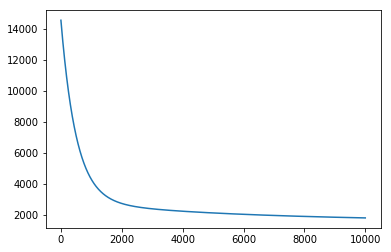

In [18]:
plt.plot(final_weights[1])

In [19]:
lr_0 = fit(X, y, lr=0.01, return_cost=True)

In [20]:
rmse(y, predict(X_normal, lr_0[0], add_bias=True))

53.707958817726443

In [21]:
lr_1 = fit(X, y, lr=0.1, return_cost=True)

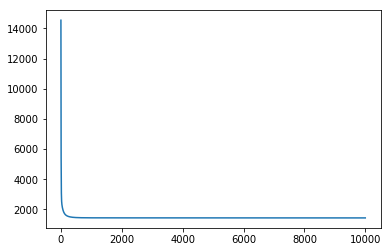

In [22]:
plt.plot(lr_1[1])

In [23]:
rmse(y, predict(X_normal, lr_1[0], add_bias=True))

53.599367825302203

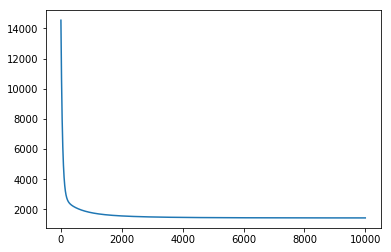

In [24]:
plt.plot(lr_0[1])

In [25]:
y.std()

77.005745869450436

The standard deviation of y is about 77. Meaning if our model were to predict the baseline of the mean every time, our model would have a rmse of 77. Our linear regression model has a rmse of ~54 which is better than the baseline. 

In [26]:
# Calculate R^2
SS_r = ((y-predict(X_normal, lr_1[0], add_bias=True))**2).sum()
SS_t = ((y-y.mean())**2).sum()
R_sq = 1-(SS_r/SS_t)
R_sq

0.51552310353125241

## Do it using sklearn and compare

In [27]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [28]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X, y)

# Make predictions using the testing set
diabetes_y_pred = regr.predict(X)


In [34]:
print("linear regression coefficients: ", regr.coef_)
print("Root mean squared error: %.2f"
      % mean_squared_error(y, diabetes_y_pred)**0.5)
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y, diabetes_y_pred))


linear regression coefficients:  [[  -2.18218161  -22.85997654  135.59008288   79.29523507 -222.36164453
   149.88939468   28.64473227   46.32511398  195.10450922   18.48736432]]
Root mean squared error: 53.48
Variance score: 0.52


In [40]:
mine = {i: lr_0[0][i][0] for i in range(11)}
mine

{0: 152.13348416289455,
 1: -0.94632793639386104,
 2: -23.587181056111305,
 3: 131.5893128348965,
 4: 80.807442795613909,
 5: -21.448143048792797,
 6: -29.775413359571505,
 7: -59.387354556568461,
 8: 34.78031546765898,
 9: 112.99428855334024,
 10: 27.135822698547234}

In [47]:
sklearns = {i: np.append(regr.intercept_, regr.coef_)[i] for i in range(11)}
sklearns

{0: 152.13348416289594,
 1: -2.1821816130705156,
 2: -22.859976540025357,
 3: 135.59008288203151,
 4: 79.295235074242939,
 5: -222.36164452848283,
 6: 149.88939468215818,
 7: 28.644732269445171,
 8: 46.325113980871073,
 9: 195.10450921686058,
 10: 18.487364318854976}

In [56]:
sorted(sklearns, key=sklearns.get)

[5, 2, 1, 10, 7, 8, 4, 3, 6, 0, 9]

In [57]:
sorted(mine, key=mine.get)

[7, 6, 2, 5, 1, 10, 8, 4, 9, 3, 0]